In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
iris = pd.read_csv("../iris-dataset.csv")
df = iris.drop('species', axis=1)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 3
#Kはクラスタサイズ 
K = X_size /c
max_iter = 100
best_J = 10000

In [ ]:
#uの最適化部分関数作成
def u_optimize(d):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],5)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    return u,result

#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([X_size,c])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**5
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**5
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**5
    
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**5*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**5*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**5*X[i]
    v=[0 for i in range(c)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    return v

for s in range (max_iter):
    centroids = X[np.random.choice(X_size,c)]
    for epoch in range(max_iter):
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        optimize_result = u_optimize(d)
        u = optimize_result[0]
        J = optimize_result[1]
        #vの更新
        v = v_calculation(u)
        new_centroids = np.array(v)
        # もしも重心が変わっていなかったら終了
        if(np.array_equal(new_centroids, centroids)):
            print("中心が変わらないのでbreakします！")
            break
        centroids =  np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J:
        u_list = u.reshape([X_size,c])
        np_cluster = np.argmax(u_list,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

0
回目のクラスタリング結果↓
4.254850237088095
[[6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
終了
1
回目のクラスタリング結果↓
4.254850237088086
[[5.93921318 2.81808909 4.39340783 1.40453004]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
終了
2
回目のクラスタリング結果↓
4.254850237088086
[[5.93921318 2.81808909 4.39340783 1.40453004]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
終了
3
回目のクラスタリング結果↓
4.254850237088086
[[5.93921318 2.81808909 4.39340783 1.40453004]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
終了
4
回目のクラスタリング結果↓
4.254850237088086
[[5.93921318 2.81808909 4.39340783 1.40453004]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
終了
5
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 

/Users/kouki/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


10
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]]
終了
11
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]]
終了
12
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]]
終了
13
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]]
終了
14
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]]
終了
15
回目のクラスタリング結果↓
4.254850237088082
[[5.0073814  3.38457268 1.49985005 0.25004123]
 [6.5809064  3.008

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0]
4.254850237088062
[[6.5809064  3.00865925 5.40692884 1.97254269]
 [5.93921318 2.81808909 4.39340783 1.40453004]
 [5.0073814  3.38457268 1.49985005 0.25004123]]
所属クラスタサイズ
50
50
50
帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[50. 50. 50.]


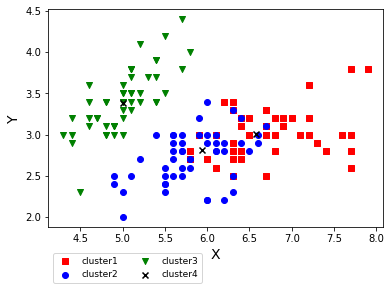

In [20]:
print(np_cluster)
print(best_J)
print(best_centroids)
print("所属クラスタサイズ")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
    
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("iris_m5.pdf",bbox_inches='tight')

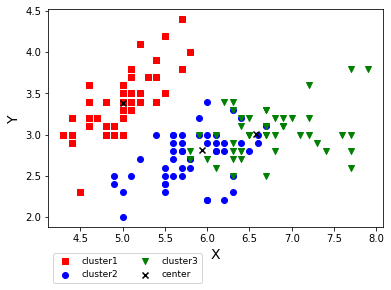

In [26]:
#2と0の交換
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==0, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==2, 0, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==100, 2, cluster_hensyuu_1)
hensyuu = cluster_hensyuu_2
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][hensyuu==i], X[:, 1][hensyuu==i], color=colors[i],marker=markers[i])
    
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("iris_m5.pdf",bbox_inches='tight')

In [24]:
#------正解率の算出
dff = pd.read_csv("../iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
dff["species"] = iris["species"].map(size_mapping)
iris_seikai = dff.values
seikai = iris_seikai[:,4]
seikaisuu = np.count_nonzero(hensyuu==seikai)
seikairitu= (np.count_nonzero(hensyuu==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))

正解率
92.0
正解数
138
クラスタサイズ確認
50
50
50


## ここまでが完成コード

In [12]:
print(np.count_nonzero(hensyuu==0))
print(np.count_nonzero(hensyuu==1))
print(np.count_nonzero(hensyuu==2))
print(np.count_nonzero(hensyuu==3))
print(np.count_nonzero(hensyuu==4))

22
14
21
21
22


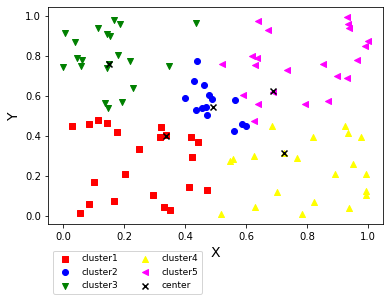

In [21]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][hensyuu==i], X[:, 1][hensyuu==i], color=colors[i],marker=markers[i])
    
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("iris_m5.pdf",bbox_inches='tight')

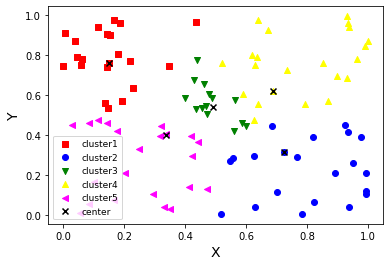

In [55]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5','center'],fontsize=9)  # 凡例を表示

plt.show()

fig.savefig("ransuu_m5.pdf")

In [18]:
print(np.count_nonzero(hensyuu==0))
print(np.count_nonzero(hensyuu==1))
print(np.count_nonzero(hensyuu==2))
print(np.count_nonzero(hensyuu==3))
print(np.count_nonzero(hensyuu==4))

22
14
21
21
22


In [247]:
#作業用セル(使用中)(制約条件変更中)（12/13）
centroids = X[np.random.choice(X_size,c)]
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの最適化
u = [0] * len(d)
#変数定義
for i in  range (len(d)):
    u[i] = cp.Variable()
#目的関数定義
Objective_function = 0 
for i  in range(len(d)):
    Objective_function += d[i]*cp.power(u[i],3)
objective = cp.Minimize(Objective_function)
# 制約条件の定義
zeroijou = []
goukeiiti = []
goukeigo = []
constraints = []
#0以上
for i in range (len(d)):
    zeroijou.append(u[i]>=0)
#合計1
for i in range (0,len(d),c):
    #下の式はcの値によって逐次変更しないといけない
    goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
#合計がクラスタサイズ
#下の式はcの値によって逐次変更しないといけない
goukeigo.append(sum(u[0:len(d):c])==K)
goukeigo.append(sum(u[1:len(d):c])==K)
goukeigo.append(sum(u[2:len(d):c])==K)
goukeigo.append(sum(u[3:len(d):c])==K)
goukeigo.append(sum(u[4:len(d):c])==K)
constraints.extend(zeroijou)
constraints.extend(goukeiiti)
constraints.extend(goukeigo)

# 問題を定義
problem = cp.Problem(objective, constraints)
# 最適化 (戻り値は最適化後に得られた値=最小値)
result = problem.solve()

#帰属度uと目的関数Jの値を抽出(ndarray型)
u_value = np.empty(0)#空のndarrayを作成
for i in range (len(d)):
    u_value = np.append(u_value,u[i].value)

u_list = u_value.reshape([99,5])

print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [249]:
#クラスタ中心計算部分関数作成
def v_calculation(u_vallue):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [250]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
#クラスタ中心計算部分関数作成
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [217]:
v

[array([0.49631367, 0.32719417]),
 array([0.54659171, 0.51736084]),
 array([0.50266058, 0.32294809]),
 array([0.50835673, 0.68137432]),
 array([0.49897542, 0.51704361])]